In [5]:
from pynq import Overlay
from pynq import MMIO

In [6]:
ol = Overlay("/home/xilinx/jupyter_notebooks/fobos3/fobos.bit")
#ol = Overlay("/home/xilinx/jupyter_notebooks/fobos3/ctrl_top_wrapper.bit")
#ol = Overlay("/home/xilinx/sdcard/bitstreams/pynq_controller.bit")

In [7]:
ol.download()

In [8]:
ol.ip_dict

{'axi_dma_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0xb03003b0>,
  'driver': pynq.lib.dma.DMA,
  'fullpath': 'axi_dma_0',
  'gpio': {},
  'interrupts': {'mm2s_introut': {'controller': 'axi_intc_0',
    'fullpath': 'axi_dma_0/mm2s_introut',
    'index': 0},
   's2mm_introut': {'controller': 'axi_intc_0',
    'fullpath': 'axi_dma_0/s2mm_introut',
    'index': 1}},
  'mem_id': 'S_AXI_LITE',
  'parameters': {'C_BASEADDR': '0x40400000',
   'C_DLYTMR_RESOLUTION': '125',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_FAMILY': 'zynq',
   'C_HIGHADDR': '0x4040FFFF',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_DRE': '0',
   'C_INCLUDE_S2MM_SF': '1',
   'C_INCLUDE_SG': '0',
   'C_MICRO_DMA': '0',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_A

In [9]:
power_addr = ol.ip_dict["powermanager_0"]["phys_addr"]

In [10]:
power_addr_range = ol.ip_dict["powermanager_0"]["addr_range"]

In [11]:
power = MMIO(power_addr, power_addr_range)

In [12]:
# Registers
power_command       = 0x00
power_status        = 0x04
power_volt3v3       = 0x08
power_current3v3    = 0x0C
power_volt5v        = 0x10
power_current5v     = 0x14
power_avgvolt3v3    = 0x18
power_maxvolt3v3    = 0x1C
power_avgcurrent3v3 = 0x20
power_maxcurrent3v3 = 0x24
power_avgvolt5v     = 0x28
power_maxvolt5v     = 0x2C
power_avgcurrent5v  = 0x30
power_maxcurrent5v  = 0x34
power_volt_output   = 0x38
power_samplecount   = 0x3C

# Commands
power_out_enable    = 0x01
power_clear         = 0x02
power_gain3v3cur    = 0x04
power_gain5vcur     = 0x10
power_trigenhw      = 0x40
power_trigsw        = 0x80

# Status
power_out_good      = 0x000
power_busy          = 0x002
#power_gain3v3cur    = 0x04
#power_gain5vcur     = 0x10
power_triggdhw      = 0x040
power_triggdsw      = 0x080
power_oflowsw       = 0x100


# Measurement Parameters
xadc_resolution = 65535  # 2^16 -1
xadc_max = 5 # Volt
xbp_shunt = 0.1 # Ohm, should be 0.1
xbp_gain = 200 # at least 25
pynq_vss = 5 # Volt Normally 5V

# Functions
def powerval(register):
    return pynq_vss * (( xadc_max/xadc_resolution * power.read(register) / (xbp_shunt * xbp_gain)))
def power_volt(register):
    return (xadc_max/xadc_resolution * power.read(register))
def power_current(register):
    return ( xadc_max/xadc_resolution * power.read(register) / (xbp_shunt * xbp_gain))





In [13]:
power.write(power_command, power_clear)

In [14]:
power.read(power_command)

2

In [15]:
power.write(power_command,0x00)

In [16]:
power.read(power_status)

0

In [17]:
power.read(power_volt3v3)

40657

In [18]:
power_volt(power_volt3v3)*1.055

3.274387731746395

In [19]:
power_volt(power_volt5v)*(1/power_volt(power_volt5v)/10+1.04)

0.10009523352456333

In [20]:
power.read(power_current3v3)

159

In [21]:
power.read(power_volt5v)

143

In [22]:
power.read(power_current5v)

253

In [23]:
power.read(power_status)

0

In [24]:
power.write(power_command, power_out_enable)

In [25]:
power.write(power_volt_output, 0x00)

In [26]:
power.write(power_command, power_clear)

In [27]:
power.write(power_command, 0x0)

In [28]:
power.write(power_command, power_trigsw | power_out_enable)

In [29]:
power_volt(power_avgvolt3v3)

3.1081864652475777

In [30]:
power_volt(power_maxvolt3v3)

3.1138323033493553

In [31]:
power_volt(power_volt3v3)

3.108110170138094

In [32]:
power_volt(power_volt5v)

3.4457160296025027

In [33]:
power_volt(power_avgvolt5v)

3.4431982909895478

In [34]:
power_volt(power_maxvolt5v)

3.4510566872663464

In [35]:
power.write(power_command, power_out_enable)

In [36]:
power.read(power_status)

129

In [37]:
power.read(power_samplecount)

597903

In [39]:
# JP1 must be in the VAR position
# J18 must be closed
# Nothing should be connected to the Target connector
import time
from collections import deque
adc_volts = []
theory_volts = []
power.write(power_volt_output, 0x00)
power.write(power_command, power_out_enable)
print("Code, ADC Value, ADC Volts, Theoretical Volts")
for i in range((2**6)):
    power.write(power_volt_output, i)
    time.sleep(1)
    t = 0
    while (power.read(power_status) & 0x01) != 0x01 and t <=10:
        t=t+1
        time.sleep(0.1)
        #adc calibration
        #calibrated_volt = 
        #cv means calibrated volt
        #cv_out = 
        adc_value.append(power.read(power_volt5v))
        theory_volts.append((365-i*5)/100)
    print(i, ",", power.read(power_volt5v), ",",((power_volt(power_volt5v))) , "," , (365-i*5)/100 )    
power.write(power_command, 0x0)
time.sleep(1)
print("Off", ",", power.read(power_volt5v), ",", ((power_volt(power_volt5v))), "," , 0)



Code, ADC Value, ADC Volts, Theoretical Volts
0 , 45146 , 3.4439612420843826 , 3.65
1 , 44478 , 3.3952849622339207 , 3.6
2 , 43861 , 3.345464255741207 , 3.55
3 , 43172 , 3.2957198443579765 , 3.5
4 , 42534 , 3.2463569085221637 , 3.45
5 , 41877 , 3.195391775387198 , 3.4
6 , 41237 , 3.145952544441901 , 3.35
7 , 40578 , 3.094300755321584 , 3.3
8 , 39913 , 3.0472266727702753 , 3.25
9 , 39255 , 2.9962615396353094 , 3.2
10 , 38590 , 2.9456015869382774 , 3.15
11 , 37935 , 2.8948653391317616 , 3.1
12 , 37309 , 2.846341649500267 , 3.05
13 , 36648 , 2.7949187457084 , 3.0
14 , 35990 , 2.747081712062257 , 2.95
15 , 35348 , 2.6949721522850387 , 2.9
16 , 34792 , 2.653772793163958 , 2.85
17 , 34094 , 2.6005188067444878 , 2.8
18 , 33460 , 2.550240329594873 , 2.75
19 , 32769 , 2.50263218127718 , 2.7
20 , 32156 , 2.4509040970473794 , 2.65
21 , 31519 , 2.4036011291676203 , 2.6
22 , 30814 , 2.353704127565423 , 2.55
23 , 30205 , 2.304951552605478 , 2.5
24 , 29512 , 2.2529945830472267 , 2.45
25 , 28881 , 2.2

In [42]:
# JP1 must be in the VAR position
# J18 must be closed
# Nothing should be connected to the Target connector
import time
import array as arr
import numpy as np
from collections import deque
adc_volts = []
theory_volts = []
multimeter_volts = np.array([3.62, 3.57, 3.52, 3.47, 3.42, 3.37, 3.32, 3.27, 3.22, 3.17, \
                             3.12, 3.08, 3.02, 2.97, 2.92, 2.87, 2.84, 2.77, 2.73, 2.68, 2.63, \
                             2.57, 2.55, 2.53, 2.47, 2.38, 2.33, 2.28, 2.23, 2.18, 2.13, 2.08, \
                             2.04, 1.99, 1.94, 1.89, 1.84, 1.81, 1.79, 1.74, 1.68, 1.64,\
                             1.59, 1.54, 1.49, 1.44, 1.39, 1.34, 1.28, 1.24, 1.19, 1.14, 1.09,\
                             0.99, 0.94, 0.89, 0.84, 0.79, 0.74, 0.69, 0.64, 0.59, 0.54, 0.49, 0])
power.write(power_volt_output, 0x00)
power.write(power_command, power_out_enable)
print("Code, ADC Value, ADC Volts, Multimeter Volts")
for i in range((2**6)):
    power.write(power_volt_output, i)
    time.sleep(1)
    t = 0
    while (power.read(power_status) & 0x01) != 0x01 and t <=10:
        t=t+1
        time.sleep(0.1)
        #adc calibration
        #calibrated_volt = 
        #cv means calibrated volt
        #cv_out = 
        adc_value.append(power.read(power_volt5v))
        theory_volts.append((365-i*5)/100)
    print(i, ",", power.read(power_volt5v), ",",((power_volt(power_volt5v))) , "," , multimeter_volts[i] )    
power.write(power_command, 0x0)
time.sleep(1)
print("Off", ",", power.read(power_volt5v), ",", ((power_volt(power_volt5v))), "," , 0)



Code, ADC Value, ADC Volts, Multimeter Volts
0 , 45127 , 3.446860456244755 , 3.62
1 , 44492 , 3.3944457160296024 , 3.57
2 , 43831 , 3.3458457312886245 , 3.52
3 , 43170 , 3.2948043030441747 , 3.47
4 , 42525 , 3.2442206454566263 , 3.42
5 , 41908 , 3.1929503318837265 , 3.37
6 , 41200 , 3.142442969405661 , 3.32
7 , 40557 , 3.092393377584497 , 3.27
8 , 39924 , 3.046845197222858 , 3.22
9 , 39256 , 2.9948119325551232 , 3.17
10 , 38624 , 2.947585259784848 , 3.12
11 , 37962 , 2.8966201266498817 , 3.08
12 , 37293 , 2.8480201419089037 , 3.02
13 , 36633 , 2.794308384832532 , 2.97
14 , 36006 , 2.7463950560769055 , 2.92
15 , 35312 , 2.6944380865186544 , 2.87
16 , 34771 , 2.6522468909742885 , 2.84
17 , 34082 , 2.601205462729839 , 2.77
18 , 33464 , 2.5523765926604103 , 2.73
19 , 32802 , 2.5037766079194324 , 2.68
20 , 32142 , 2.452124818799115 , 2.63
21 , 31483 , 2.4016174563210497 , 2.57
22 , 30853 , 2.3537804226749066 , 2.55
23 , 30183 , 2.301365682459754 , 2.53
24 , 29526 , 2.2532997634851606 , 2.47

In [55]:
import time
power.write(power_volt_output, 0x00)
power.write(power_command, power_out_enable)
adc_volts.clear()
theory_volts.clear()
for i in range((2**6)):
    power.write(power_volt_output, i)
    time.sleep(1)
    t = 0
    adc_volts.append(power_volt(power_volt5v))
    theory_volts.append((365-i*5)/100)
    while (power.read(power_status) & 0x01) != 0x01 and t <=10:
        t=t+1
        time.sleep(0.1)

power.write(power_command, 0x0)
time.sleep(1)
adc_volts.append(power_volt(power_volt5v))
theory_volts.append(0)
print(adc_volts)
print(theory_volts)


[3.442435339894713, 3.3962005035477225, 3.3448538948653392, 3.2927443350881207, 3.2453650720988785, 3.1953154802777144, 3.146410315098802, 3.091325246051728, 3.044632639047837, 2.9940489814602884, 2.9457541771572444, 2.8964675364309147, 2.846646829938201, 2.7942320897230486, 2.748836499580377, 2.693751430533303, 2.65293354695964, 2.6009765774013887, 2.551689936675059, 2.4984359502555886, 2.4559395742732892, 2.4014648661020828, 2.353017471580072, 2.304188601510643, 2.2552071412222476, 2.2019531548027773, 2.15228503852903, 2.1023117418173496, 2.055924315251392, 2.004577706569009, 1.955367360952163, 1.903486686503395, 1.8652628366521706, 1.8160524910353246, 1.768978408484016, 1.7157244220645456, 1.6675822079804685, 1.6194399938963913, 1.569085221637293, 1.5194934004730296, 1.4732585641260396, 1.4240482185091936, 1.3745326924544137, 1.327763790341039, 1.2799267566948958, 1.232318608377203, 1.1828793774319066, 1.1387045090409704, 1.0972762645914398, 1.0479133287556268, 1.0040436408026245, 0

[-0.20756466010528696, -0.20379949645227757, -0.20514610513466058, -0.2072556649118793, -0.2046349279011217, -0.20468451972228552, -0.203589684901198, -0.20867475394827162, -0.20536736095216312, -0.20595101853971176, -0.2042458228427555, -0.2035324635690854, -0.20335317006179876, -0.2057679102769514, -0.20116350041962328, -0.2062485694666969, -0.1970664530403603, -0.19902342259861117, -0.19831006332494105, -0.20156404974441156, -0.19406042572671067, -0.19853513389791733, -0.19698252841992803, -0.19581139848935702, -0.19479285877775254, -0.1980468451972226, -0.1977149614709699, -0.19768825818265023, -0.1940756847486078, -0.19542229343099127, -0.194632639047837, -0.19651331349660506, -0.1847371633478292, -0.18394750896467538, -0.18102159151598385, -0.18427557793545435, -0.18241779201953157, -0.18056000610360878, -0.18091477836270697, -0.18050659952697035, -0.1767414358739603, -0.17595178149080648, -0.17546730754558637, -0.17223620965896091, -0.1700732433051042, -0.16768139162279683, -0.1

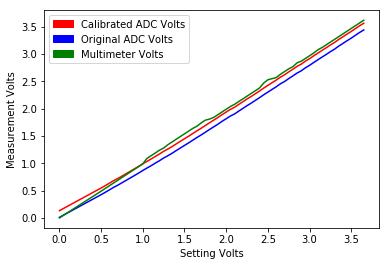

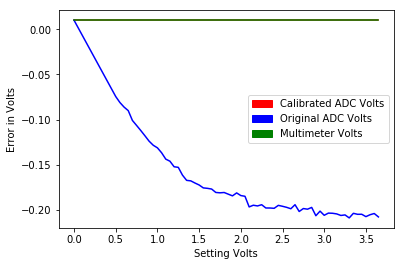

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit,least_squares
#try a cauchy loss for least squares, may try something else
#Trying polyfit
#tried doing a curve fit with degree 2 poly with less accurate result
#Anything theory volts should be really called setting volts
#This is because notebook is setting these voltage values
def fundeg2(x,a,b,c):
    return ((a*(x**2)) + (b*x) + c)
def fundeg1(x,a,b):
    return (a*x + b)
code = np.arange(0,65,1)
slope,intercept,r_value,p_value,std_err = stats.linregress(adc_volts,theory_volts)
slopemm, interceptmm, r_valuemm, p_valuemm,std_errmm = stats.linregress(adc_volts,multimeter_volts)
degreetwofunc = curve_fit(fundeg2,adc_volts,theory_volts)
degreetwofuncmm = curve_fit(fundeg2,adc_volts,multimeter_volts)
#res_lsq = least_squares(fundeg1,adc_volts, loss='soft_l1', f_scale=0.1, args=(slope,intercept ))
xsq,xlin,xint = np.polyfit(adc_volts,theory_volts,2)
xsqmm,xlinmm,xintmm = np.polyfit(adc_volts,multimeter_volts,2)
#print(parafit)
#print(xsq)
firstfuncparams = degreetwofunc[0]
#print(degreetwofunc)
#print(degreetwofunc[0])

corrected_adc = []
corrected_adc_exp = []
corrected_adcmm = []
corrected_adc_expmm = []
#using zip method here to implement error calculation
adc_error = []
mm_error = []
corrected_adc_error = []
#zip1
zip1 = zip(adc_volts,theory_volts)
for list1_i,list2_i in zip1:
    adc_error.append(list1_i-list2_i)

print(adc_error)
#adc_error = adc_volts - theory_volts
#zip2
zip2 = zip(multimeter_volts,theory_volts)
for list3_i,list4_i in zip2:
    mm_error.append(list1_i-list2_i)
    
print(mm_error)
#mm_error = multimeter_volts - theory_volts

#corrected_adc_error = corrected_adcmm - theory_volts
print(slope)
print(intercept)
print(2*intercept)
print(std_err)
print(r_value**2)
print(slopemm)
print(interceptmm)
print(2*interceptmm)
print(std_errmm)
print(r_valuemm**2)
#no clue why doubling intercept value improves line fit
corrected_adc = (adc_volts*int(slope)) + 2*intercept
corrected_adcmm = (adc_volts*int(slopemm)) + interceptmm
corrected_adc_exp = np.square(adc_volts)*int(xsq) + adc_volts*int(xlin) + xint
corrected_adc_expmm = np.square(adc_volts)*int(xsqmm) + adc_volts*int(xlinmm) + xintmm
print(corrected_adc)
print(corrected_adc_exp)
#zip3
#Has to happen after correction happens

zip3 = zip(corrected_adcmm,theory_volts)
for list5_i,list6_i in zip3:
    corrected_adc_error.append(list1_i-list2_i)
    
print(corrected_adc_error)
#plt.figure()
#fig,plts = plt.subplots(3,2)
plt.figure(1)
red_patch1 = mpatches.Patch(color='red', label='Calibrated ADC Volts')
blue_patch1 = mpatches.Patch(color='blue', label='Original ADC Volts')
red_patch2 = mpatches.Patch(color='red', label='Calibrated ADC Volts')
blue_patch2 = mpatches.Patch(color='blue', label='Theory volts')
red_patch3 = mpatches.Patch(color='red', label='')
green_patch1 = mpatches.Patch(color='green', label='Multimeter Volts')
red_patch4 = mpatches.Patch(color='red', label='Blue data')
blue_patch4 = mpatches.Patch(color='blue', label='Blue data')
#plt.legend(handles=[red_patch1,blue_patch1])
plt.show()
#plt.subplot(211)
plt.plot(theory_volts,corrected_adcmm,'r',theory_volts,adc_volts,'b',theory_volts,multimeter_volts,'g')
plt.xlabel('Setting Volts')
plt.ylabel('Measurement Volts')
#plt.plot(code,adc_volts,'r',code,theory_volts,'b')
plt.legend(handles=[red_patch1,blue_patch1,green_patch1])
#plt.subplot(212)
#plt.plot(code,corrected_adc,'r',code,theory_volts,'b')
#plt.legend(handles=[red_patch2,blue_patch1])
plt.figure(2)
#plt.subplot(211)
#plt.plot(code,corrected_adc_exp,'g',code,theory_volts,'b')
#plt.plot(code,adc_volts,'r',code,multimeter_volts,'b')
plt.plot(theory_volts,corrected_adc_error,'r',theory_volts,adc_error,'b',theory_volts,mm_error,'g')
plt.xlabel('Setting Volts')
plt.ylabel('Error in Volts')
plt.legend(handles=[red_patch1,blue_patch1,green_patch1])
#plt.subplot(212)
#plt.plot(code,corrected_adcmm,'r',code,multimeter_volts,'b')
#plt.legend(handles=[red_patch2,blue_patch2])
#plt.plot(corrected_adcmm,multimeter_volts)
#plt.figure(3)
#plt.subplot(211)
#plt.plot(code,corrected_adcmm,'r',code,multimeter_volts,'b')
#plt.subplot(212)
#plt.plot(code,corrected_adc_expmm,'g',code,multimeter_volts,'b')


1.03986841725
0.0968469608262
0.193693921652
0.00299761423385
0.999476751545
1.02358522587
0.123322773358
0.246645546716
0.00523457472219
0.998355096675


ValueError: x and y must have same first dimension, but have shapes (0,) and (65,)

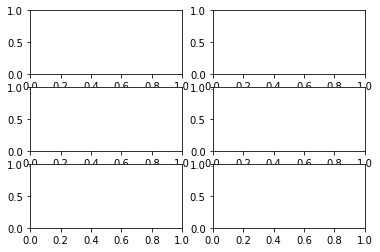

In [44]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit,least_squares


def fundeg2(x,a,b,c):
    return ((a*(x**2)) + (b*x) + c)
def fundeg1(x,a,b):
    return (a*x + b)
code = np.arange(0,65,1)
slope,intercept,r_value,p_value,std_err = stats.linregress(adc_volts,theory_volts)
slopemm, interceptmm, r_valuemm, p_valuemm,std_errmm = stats.linregress(adc_volts,multimeter_volts)
degreetwofunc = curve_fit(fundeg2,adc_volts,theory_volts)
degreetwofuncmm = curve_fit(fundeg2,adc_volts,multimeter_volts)
#res_lsq = least_squares(fundeg1,adc_volts, loss='soft_l1', f_scale=0.1, args=(slope,intercept ))
xsq,xlin,xint = np.polyfit(adc_volts,theory_volts,2)
xsqmm,xlinmm,xintmm = np.polyfit(adc_volts,multimeter_volts,2)
#print(parafit)
#print(xsq)
firstfuncparams = degreetwofunc[0]
#print(degreetwofunc)
#print(degreetwofunc[0])

corrected_adc = []
corrected_adc_exp = []
corrected_adcmm = []
corrected_adc_expmm = []
print(slope)
print(intercept)
print(2*intercept)
print(std_err)
print(r_value**2)
print(slopemm)
print(interceptmm)
print(2*interceptmm)
print(std_errmm)
print(r_valuemm**2)

fig,plts = plt.subplots(3,2)
plts[0,0].plot(corrected_adc,theory_volts)

#plt.plot(code,corrected_adc_expmm,'g',code,multimeter_volts,'b')
plt.show()

In [58]:
power.read(power_current3v3)

206

In [115]:
power.read(power_current5v)

1587

In [60]:
power.read(power_maxcurrent3v3)

258

In [34]:
power_current(power_maxcurrent3v3)

0.002525368123903258

In [35]:
power_current(power_current5v)

0.015182726787212938

In [123]:
power_current(power_current3v3)

0.0012130922407873656

In [37]:
# JP1 must be in the VAR position
# J18 must be open for current readings
# Nothing should be connected to the Target connector
import time
from collections import deque
power.write(power_volt_output, 0x00)
power.write(power_command, power_out_enable)
print("Code, ADC Value, ADC Current, Theoretical Current")
for i in range((2**6)):
    power.write(power_volt_output, i)
    time.sleep(3)
    t = 0
    while (power.read(power_status) & 0x01) != 0x01 and t <=10:
        t=t+1
        time.sleep(0.1)
        #adc calibration
        #calibrated_volt = 
        #cv means calibrated volt
        #cv_out = 
        adc_value.append(power.read(power_current5v))
        #theory_volts.append((365-i*5)/100)
    print(i, ",", power.read(power_current5v), ",",((power_volt(power_current5v))) , "," , (15+i*5)/1000 )    
power.write(power_command, 0x0)
time.sleep(3)
print("Off", ",", power.read(power_current5v), ",", ((power_volt(power_current5v))), "," , 0)

Code, ADC Value, ADC Current, Theoretical Current
0 , 261 , 0.018310826276035707 , 0.015
1 , 244 , 0.019226367589837492 , 0.02
2 , 257 , 0.019378957808804456 , 0.025
3 , 252 , 0.01953154802777142 , 0.03
4 , 257 , 0.01808194094758526 , 0.035
5 , 256 , 0.01739528496223392 , 0.04
6 , 256 , 0.01892118715190356 , 0.045
7 , 236 , 0.01808194094758526 , 0.05
8 , 248 , 0.017471580071717403 , 0.055
9 , 268 , 0.020828564888990615 , 0.06
10 , 274 , 0.01884489204242008 , 0.065
11 , 252 , 0.020523384451056687 , 0.07
12 , 262 , 0.021972991531242846 , 0.075
13 , 242 , 0.018539711604486152 , 0.08
14 , 262 , 0.019302662699320974 , 0.085
15 , 252 , 0.01739528496223392 , 0.09
16 , 253 , 0.018158236057068743 , 0.095
17 , 230 , 0.01998931868467231 , 0.1
18 , 207 , 0.01731898985275044 , 0.105
19 , 256 , 0.019684138246738384 , 0.11
20 , 260 , 0.01617456321049821 , 0.115
21 , 241 , 0.019684138246738384 , 0.12
22 , 248 , 0.018997482261387044 , 0.125
23 , 243 , 0.017547875181200885 , 0.13
24 , 238 , 0.0198367284